In [1]:
import operator
from typing import Annotated, List
# Recommended for type safety in LangGraph
from typing_extensions import TypedDict 

# BaseMessage is part of the langchain_core library
from langgraph.graph.message import add_messages

# Define the state schema
class ChatbotState(TypedDict):
    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # Flag indicating that the order is placed and completed.
    finished: bool

    # This is the message with which the system opens the conversation.
    WELCOME_MSG = "Welcome to the Chatbot. Type `q` to quit. How may I serve you today?"


In [2]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages.ai import AIMessage
from typing import Literal

# Initialize the state graph with the defined schema
graph_builder = StateGraph(ChatbotState)

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite", temperature=0.7)

def human_node(state: ChatbotState) -> ChatbotState:
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If user is trying quit, flag the conversation as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def chatbot_with_welcome_msg(state: ChatbotState) -> ChatbotState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke(state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=state.ELCOME_MSG)

    return state | {"messages": [new_output]}

def maybe_exit_human_node(state: ChatbotState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

In [3]:
from langchain_core.tools import tool

@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """


In [4]:
from langgraph.prebuilt import ToolNode

# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)

def maybe_route_to_tools(state: ChatbotState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"

def chatbot_with_tools(state: ChatbotState) -> ChatbotState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke(state["messages"])
    else:
        new_output = AIMessage(content=state.WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}

In [5]:
# Set up the initial graph based on our state definition.
graph_builder = StateGraph(ChatbotState)

# Add the functions to the app graph as nodes called "chatbot", "human", and "tools".
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Add conditional edges to route between nodes.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

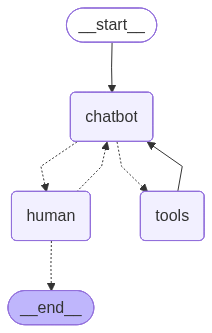

In [6]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [7]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 10}

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]}, config=config)

print(state["messages"][-1].content)

Model: I can help you with your food order, like providing the menu. What would you like to do? 
quit
